In [1]:
#!pip install pandas
#!pip install tensorflow-gpu
#!pip install matplotlib
#!pip install sklearn

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
## Ref: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE ## Auto tune tf.data hyper parameters for 
## data loading performance
FILE_PATH = '/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data/'
#GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * 8#strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

# Data Preperation

In [4]:
filenames = tf.io.gfile.glob(str(FILE_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(FILE_PATH + '/chest_xray/val/*/*')))

## since there are 16 images for the validation set, first both train and test sets are
## combined and then the dataset is split with 80, 20 rule (80% training, 20% testing)
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))



Normal images count in training set: 1068
Pneumonia images count in training set: 3117


In [6]:
## put the file names in a tf tensor
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

## view few of the file names
for f in train_list_ds.take(5):
    print(f.numpy())

b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data//chest_xray/train/NORMAL/NORMAL2-IM-1344-0001.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data//chest_xray/train/PNEUMONIA/person8_bacteria_37.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data//chest_xray/train/PNEUMONIA/person549_bacteria_2307.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data//chest_xray/train/PNEUMONIA/person1691_bacteria_4481.jpeg'
b'/media/akaaku13m/af04068d-3c77-49e2-977e-15b2e7dd348e/research_assistance_work/courses/PINNDL/local/data//chest_xray/train/PNEUMONIA/person500_bacteria_2110.jpeg'


In [7]:
## cardinality gives the number of unique elements in the dataset
## Ref: https://orangematter.solarwinds.com/2020/01/05/what-is-cardinality-in-a-database/
## Ref: https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
## View the two classes
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(FILE_PATH + "/chest_xray/train/*"))])
CLASS_NAMES



array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [9]:
## Returns 0 or 1 (False or True) labels
## 1 indicates the Pneumonia class and 0 indicates a Normal class
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [11]:
## from a given file path get the label and the corresponding image
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(AUTOTUNE)

-1


In [13]:
## check the new dataset
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())



Image shape:  (180, 180, 3)
Label:  False


In [14]:
## Prepare a test dataset for validating the model performances after training
test_list_ds = tf.data.Dataset.list_files(str(FILE_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [15]:
## For caching, repeat, and prefetch, please refer to
## Ref: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str): ## if caching to a file
            ds = ds.cache(cache)
        else: ## cache in memory
            ds = ds.cache()
    ## shuffle data, otherwise, data will be cached with the same patten (not random)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
## prepare the dataset for training
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [17]:
## show sample batch of images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

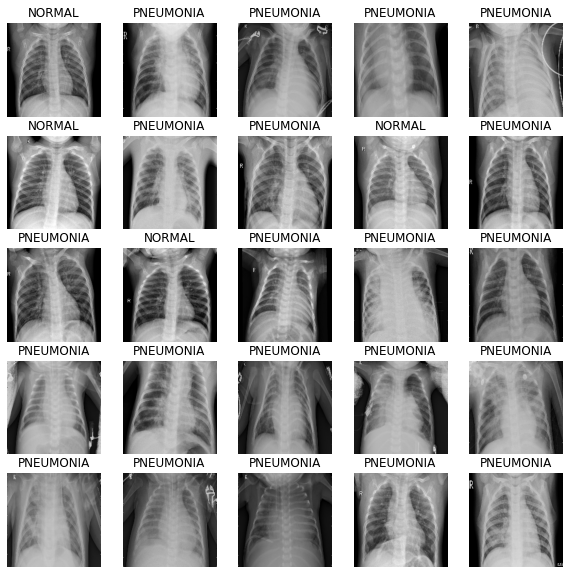

In [18]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Model Building

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
## Get the binary class ratios for correcting the imbalance
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.07108326])

In [23]:
## weigh each class according to the imbalance
## The idea is to multiply the loss with the weight, so the model focus more on the class that has a
## larger weight than a class with a smaller weight
## for loss weighting and focal loss, please refer to
## Ref: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


In [24]:
model = build_model()
## use accuracy, precision and recall to monitor the model train val performances
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

## since this is a binary classification problem, we can use the binary cross entropy loss function
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

KeyboardInterrupt: 

In [54]:
# ## Train the model
# history = model.fit(
#     train_ds,
#     steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#     class_weight=class_weight,
# )



In [55]:
## save the best model using checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)
## To prevent the model from becoming worst (e.g. overfitting) stop the training before the issues start using the Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [56]:
## Decay the learning rate throught the training so the updates will gradually take smaller steps than at the begining.
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        ## scale the initial learning rate by an exponential function 0.1^(e/s)
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)



In [57]:


history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)



Epoch 1/100
32/32 [==============================] - 16s 502ms/step - loss: 0.4160 - accuracy: 0.7993 - precision: 0.9378 - recall: 0.7807 - val_loss: 0.7023 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 2/100
32/32 [==============================] - 9s 284ms/step - loss: 0.1983 - accuracy: 0.9229 - precision: 0.9749 - recall: 0.9198 - val_loss: 2.2238 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/100
32/32 [==============================] - 9s 280ms/step - loss: 0.1432 - accuracy: 0.9473 - precision: 0.9832 - recall: 0.9450 - val_loss: 2.9916 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 4/100
32/32 [==============================] - 9s 275ms/step - loss: 0.1307 - accuracy: 0.9463 - precision: 0.9862 - recall: 0.9407 - val_loss: 3.2853 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000
Epoch 5/100
32/32 [==============================] - 9s 274ms/step - loss: 0.1026 - accuracy: 0.962

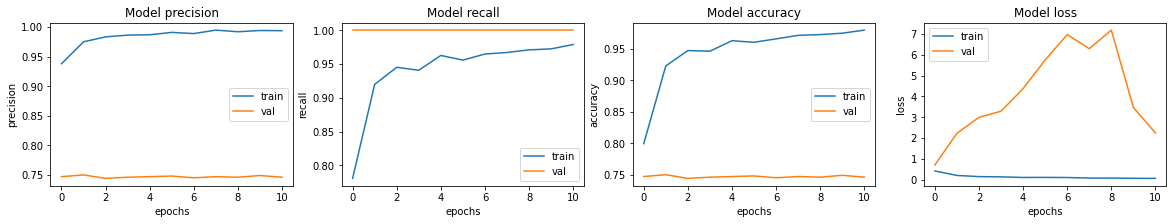

In [58]:
## visualize the performance
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])